In [125]:
%load_ext autoreload
%autoreload 2

import datetime
import gc
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import lightgbm as lgb
import re
import json

import shap
shap.initjs()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg' 

from preprocessing import load_messages, format_forks, replace_substring
from preprocessing import get_currency, get_tax, apply_tax
from preprocessing import add_levels_cols, add_levels_forks
from preprocessing import get_quantiles, estimate_level_forks
from preprocessing import box_plot_by_level
from preprocessing import TIME_RANGES_DICT, YEAR_RANGES_DICT, LEVELS_DICT
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(rc={'figure.figsize': (12, 9)})
sns.set_palette("bright")
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### –ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–∞—è –æ—á–∏—Å—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö 
–î–ª—è –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è –º—ã –∏—Å–ø–æ—å–∑–æ–≤–∞–ª–∏ —Å–≤–µ–∂–∏–π –¥–∞–º–ø —Å–ª–∞–∫–∞ ODS –æ—Ç 06 –º–∞—Ä—Ç–∞ 2021 –≥–æ–¥–∞.<br>
–ö–∞–Ω–∞–ª—ã jobs –∏ jobs hr. –ó–∞–≥—Ä—É–∑–∏–º —Å–æ–æ–±—â–µ–Ω–∏—è –≤ pandas df –∏ –æ—á–∏—Å—Ç–∏–º –æ—Ç –ª–∏—à–Ω–µ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏.

In [126]:
messages = load_messages('jobs', 'jobs_hr')

–ó–∞–≥—Ä—É–∂–µ–Ω–æ 50827 c–æ–æ–±—â–µ–Ω–∏–π
	–£–¥–∞–ª–µ–Ω—ã —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ —Å–æ–æ–±—â–µ–Ω–∏—è: 6990 —Å–æ–æ–±—â–µ–Ω–∏–π
	–î–∞—Ç–∞ –∏ –≤—Ä–µ–º—è –æ–∫—Ä—É–≥–ª–µ–Ω—ã –¥–æ —Å–µ–∫—É–Ω–¥ –∏ –ø–µ—Ä–µ–≤–µ–¥–µ–Ω—ã –≤ datetime —Ñ–æ—Ä–º–∞—Ç
	–¢–µ–∫—Å—Ç –ø—Ä–∏–≤–µ–¥–µ–Ω –∫ –º–∞–ª–µ–Ω—å–∫–∏–º –±—É–∫–≤–∞–º –∏ –æ—á–∏—â–µ–Ω –æ—Ç –ª–∏—à–Ω–∏—Ö –ø—Ä–æ–±–µ–ª–æ–≤
–û—Å—Ç–∞–ª–æ—Å—å 43837 c–æ–æ–±—â–µ–Ω–∏–π


### –ö–æ–ª-–≤–æ —Å–æ–æ–±—â–µ–Ω–∏–π

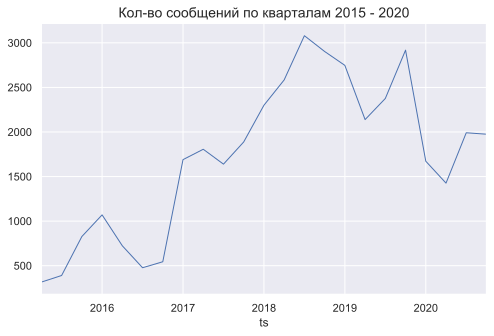

In [127]:
plt.figure(figsize = (8, 5))
messages[messages.ts.dt.year < 2021].resample('Q', on = 'ts')['ts'].count().plot(linewidth=1,
                                                                                 label='–≤—Å–µ–≥–æ')
plt.title('–ö–æ–ª-–≤–æ —Å–æ–æ–±—â–µ–Ω–∏–π –ø–æ –∫–≤–∞—Ä—Ç–∞–ª–∞–º 2015 - 2020', size=14)
plt.show()

–û–±—â–µ–µ –∫–æ–ª-–≤–æ —Å–æ–æ–±—â–µ–Ω–∏–π –¥–æ—Å—Ç–∏–≥–ª–æ <b>–º–∞–∫—Å–∏–º—É–º–∞ –≤ 3 –∫–≤–∞—Ä—Ç–∞–ª–µ 2018 –≥–æ–¥–∞</b>.<br>
–ü–æ—Å–ª–µ —ç—Ç–æ–≥–æ –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç—å —Å–Ω–∏–∂–∞–ª–∞—Å—å - —Ä–µ–∑–∫–æ–µ <b>–ø–∞–¥–µ–Ω–∏–µ –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏ –ø—Ä–æ–∏–∑–æ—à–ª–æ –≤ 2020 –≥–æ–¥—É</b>

#### –ß—Ç–æ —ç—Ç–æ –∫–æ—Ä–æ–Ω–∞–∫—Ä–∏–∑–∏—Å –∏–ª–∏ —Ö–∞–π–ø –ø–æ data science —É–∂–µ –ø—Ä–æ—à–µ–ª?

–ó–¥–µ—Å—å –º—ã —Å–º–æ—Ç—Ä–∏–º –Ω–∞ –≤—Å–µ —Å–æ–æ–±—â–µ–Ω–∏—è - —ç—Ç–æ –∏ —Å–∞–º–∏ –≤–∞–∫–∞–Ω—Å–∏–∏ –∏ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π.<br>
–î–æ 2017 –≥–æ–¥–∞ —Ç—Ä–µ–¥–æ–≤ –≤–æ–æ–±—â–µ –Ω–µ –±—ã–ª–æ –∏ –≤—Å–µ —Å–æ–æ–±—â–µ–Ω–∏—è —Å—ã–ø–∞–ª–∏—Å—å –≤ –æ–±—â–∏–π –∫–∞–Ω–∞–ª.<br>
–£ —á–∞—Å—Ç–∏ —Å–æ–æ–±—â–µ–Ω–∏–π –∏ —Å–µ–π—á–∞—Å –Ω–µ—Ç —Ç—Ä–µ–¥–∞ - –µ—Å–ª–∏ –Ω–∏–∫—Ç–æ –Ω–µ –æ—Å—Ç–∞–≤–∏–ª –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π.<br>

–î–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–≥–æ –∞–Ω–∞–ª–∏–∑–∞ –Ω–∞–º –Ω—É–∂–Ω–æ –æ—Ç–¥–µ–ª–∞—Ç—å —Å–æ–æ–±—â–µ–Ω–∏—è —Å –≤–∞–∫–∞–Ω—Å–∏—è–º–∏ –æ—Ç –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π.<br>
–°–∞–º—ã–π –ø—Ä–æ—Å—Ç–æ–π –ø–æ–¥—Ö–æ–¥ - —ç—Ç–æ —Å—á–∏—Ç–∞—Ç—å –≤–∞–∫–∞–Ω—Å–∏–µ–π –≤—Å–µ —Å–æ–æ–±—â–µ–Ω–∏—è —Å –∫–æ—Ç–æ—Ä—ã—Ö –Ω–∞—á–∏–Ω–∞–µ—Ç—Å—è —Ç—Ä–µ–¥ (thread_ts = ts).<br>
–ù–æ —Ç–æ–≥–¥–∞ –º—ã –ø–æ—Ç–µ—Ä—è–µ–º –≤—Å—é —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –∑–∞ 2015-2016 –≥–æ–¥–∞.<p>
    
–í—Ç–æ—Ä–æ–π –≤–∞—Ä–∏–∞–Ω—Ç - —ç—Ç–æ –æ–±—É—á–∏—Ç—å –ø—Ä–æ—Å—Ç—É—é –º–æ–¥–µ–ª—å –Ω–∞ —ç—Ç–æ–π –º–µ—Ç–∫–µ –∏ —Ä–∞–∑–¥–µ–ª–∏—Ç—å —Å –µ–µ –ø–æ–º–æ—â—å—é —Å–æ–æ–±—â–µ–Ω–∏—è –±–µ–∑ —Ç—Ä–µ–¥–∞.<br>

### –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è —Å–æ–æ–±—â–µ–Ω–∏–π –Ω–∞ –≤–∞–∫–∞–Ω—Å–∏–∏ –∏ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏

–í –∫–∞—á–µ—Å—Å—Ç–≤–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –±—É–¥–µ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å count –ø–æ –≤—Å–µ–º —Å–ª–æ–≤–∞–º –≤ —Å–æ–æ–±—â–µ–Ω–∏–∏.

In [128]:
df = messages.loc[~messages.thread_ts.isna(),:]

# –ì–µ–Ω–µ—Ä–∏—Ä—É–µ–º –º–µ—Ç–∫—É –¥–ª—è –æ–±—É—á–µ–Ω–∏—è
df['is_job'] = (df['thread_ts'] == df['ts']).astype('int8')


# –í—ã–±–∏—Ä–∞–µ–º —Ç–æ–ª—å–∫–æ –Ω—É–∂–Ω—ã–µ –¥–ª—è –æ–±—É—á–µ–Ω—è–∏ –∫–æ–ª–Ω–∫–∏
df = df.loc[:,['is_job', 'text']].reset_index(drop=True)

# –î–µ–ª–∏–º –¥–∞—Ç–∞—Å–µ—Ç –Ω–∞ —Ç—Ä–µ–π–Ω –∏ —Ç–µ—Å—Ç
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, ['text']], df['is_job'],
                                                    test_size = 0.3, random_state = 555)

# CountVectorizer –¥–ª—è —Ç–µ–∫—Å—Ç–∞
countvectorizer = CountVectorizer(ngram_range=(1, 2), max_features=2000)
countvectorizer.fit(X_train['text'])
word_cols = countvectorizer.get_feature_names()

# –î–µ–ª–∏–º –Ω–∞ —Ç—Ä–µ–π–Ω –∏ —Ç–µ—Å—Ç –∏ –æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å
X_train = countvectorizer.transform(X_train['text']).toarray() 
X_test = countvectorizer.transform(X_test['text']).toarray()

gbm1 = lgb.LGBMClassifier(num_leaves=11, n_estimators=300, feature_fraction=0.1, bagging_fraction=0.3)
gbm1.fit(X_train, y_train.values)

del X_train, y_train, df
gc.collect()

[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1


3143

#### –ö–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏
<p>–ö–∞—á–µ—Å—Ç–≤–∞ —ç—Ç–æ–π –ø—Ä–æ—Å—Ç–æ–π –º–æ–¥–µ–ª–∏ –±–æ–ª–µ–µ —á–µ–º –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –¥–ª—è –ø–æ—Å—Ç–∞–≤–ª–µ–Ω–Ω–æ–π –∑–∞–¥–∞—á–∏.<br>
–¢–µ–º –±–æ–ª–µ–µ, —á—Ç–æ —Ä–∞–∑–º–µ—Ç–∫–∞ –¥–ª—è –æ–±—É—á–µ–Ω–∏—è —à—É–º–Ω–∞—è –∏ –Ω–µ –Ω–∞ 100% —Ç–æ—á–Ω–∞—è.<p>

In [129]:
# –°—á–∏—Ç–∞–µ–º –º–µ—Ç—Ä–∏–∫–∏
accuracy_baseline = round(sum(y_test == 0) / len(y_test) * 100, 1)
print(f'Accuracy –¥–ª—è –Ω–∞–∏–≤–Ω–æ–π –º–æ–¥–µ–ª–∏ {accuracy_baseline}')
pred = gbm1.predict(X_test)
accuracy_model = round(sum(y_test == pred) / len(y_test) * 100, 1)
print(f'Accuracy –¥–ª—è –º–æ–¥–µ–ª–∏ {accuracy_model}')
print(f'F1 score {f1_score(y_test, pred)}')

df = countvectorizer.transform(messages['text']).toarray()
messages['is_job'] = gbm1.predict(df)
# del df

Accuracy –¥–ª—è –Ω–∞–∏–≤–Ω–æ–π –º–æ–¥–µ–ª–∏ 92.8
Accuracy –¥–ª—è –º–æ–¥–µ–ª–∏ 99.7
F1 score 0.9773976786805131


#### –í–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
–í–∞–∫–∞–Ω—Å–∏–∏ –∏ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏ –ª–µ–≥–∫–æ —Å–ø–ª–∏—Ç—è—Ç—Å—è –ø–æ –∏—Å–ø–æ–ª—å–∑—É–µ–º—ã–º —Å–ª–æ–≤–∞–º.
–ù–∞–ø—Ä–∏–º–µ—Ä –Ω–∞ –≤–∞–∫–∞–Ω—Å–∏—é —É–∫–∞–∑—ã–≤–∞—é—Ç —Ç–∞–∫–∏–µ —Å–ª–æ–≤–∞: 
<li> –Ω–∞–≤—ã–∫–∏: python, sql, data, –∞–Ω–≥–ª–∏–π—Å–∫–∏–π
<li> —Å—Å—ã–ª–∫–∏ –∏ email: http, https, mailto
<li> —Å–ª–æ–≤–∞ —Å–≤—è–∑–∞–Ω–Ω—ã–µ —Å –≤–∏–ª–∫–æ–π –∑–ø: –≤–∏–ª–∫–∞, –æ—Ç, fork, 200, 50 –∏ —Ç.–¥.
<li> –¥—Ä—É–≥–∏–µ —Å–ª–æ–≤–∞ —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞–µ–º—ã–µ –≤ –æ–ø–∏—Å–∞–Ω–∏–∏ –≤–∞–∫–∞–Ω—Å–∏–π: –æ–ø—ã—Ç, –ø—Ä–∏–≤–µ—Ç (–≤ –∫–æ–º–º–µ–Ω—Ç–∞—Ö –ª—é–¥–∏ —Ä–µ–¥–∫–æ –∑–¥–æ—Ä–æ–≤–∞—é—Ç—Å—è), –Ω–∞, –∏—â–µ–º, –æ—Ñ–∏—Å, –º–æ—Å–∫–≤–∞, —Ç—Ä–µ–±–æ–≤–∞–Ω–∏—è<p>
    
–ù–∞ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π —É–∫–∞–∑—ã–≤–∞—é—Ç —Ä–∞–∑–≥–æ–≤–æ—Ä–Ω—ã–µ —Å–ª–æ–≤–∞ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–Ω—ã–µ –¥–ª—è –æ—Ç–≤–µ—Ç–æ–≤:<br>
–≤–æ—Ç, –ø—Ä–æ—Å—Ç–æ, —Ç–∞–∫, —É–∂–µ, –µ—Å—Ç—å, gt (–∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Ü–∏—Ç–∞—Ç—ã)<p>

–ù–∏–∂–µ –º–æ–∂–Ω–æ –ø–æ—Å–æ–º–æ—Ç—Ä–µ—Ç—å top50 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –∏–∑ –º–æ–¥–µ–ª–∏ –ø–æ –≤–µ—Ä—Å–∏–∏ shap

#### –ù–∞—Ä–∏—Å—É–µ–º —à–∞–ø –¥–ª—è –º–æ–¥–µ–ª–∏

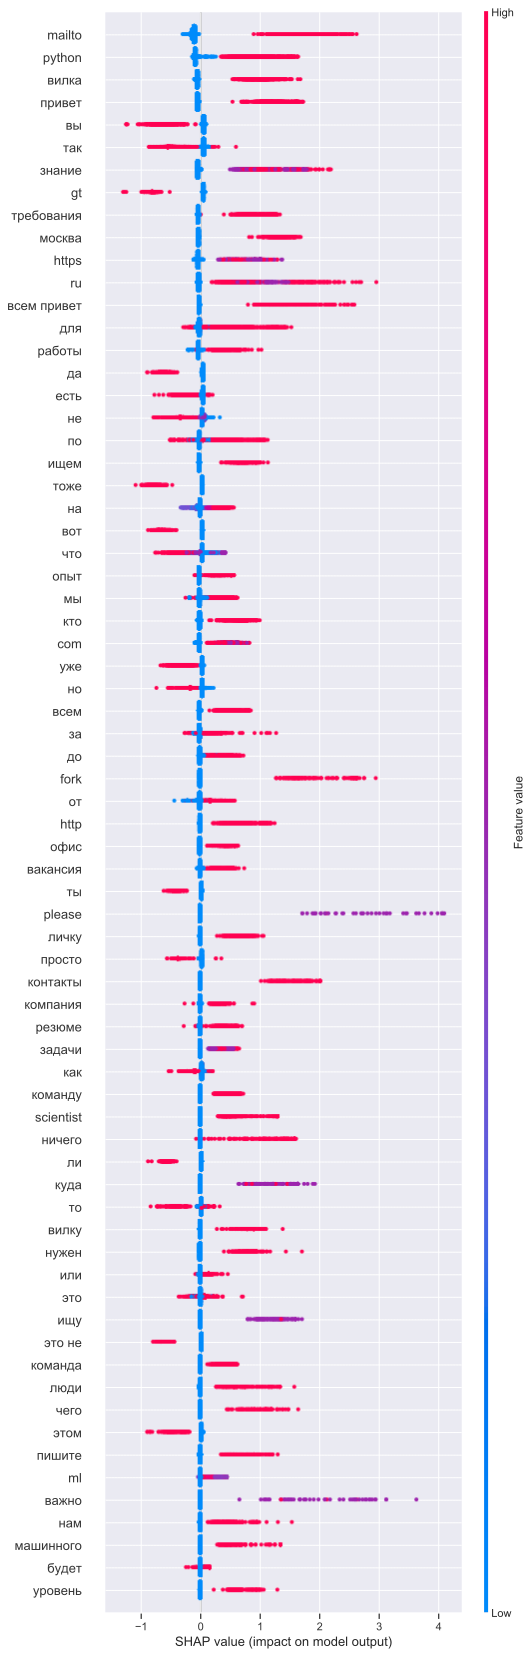

In [130]:
explainer = shap.TreeExplainer(gbm1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, max_display=70, feature_names=word_cols)

### –ö–æ–ª-–≤–æ —Å–æ–æ–±—â–µ–Ω–∏–π —Å –≤–∞–∫–∞–Ω—Å–∏—è–º–∏

–¢–µ–ø–µ—Ä—å, —Å –ø–æ–º–æ—â—å—é –Ω–∞—à–µ–π –º–æ–¥–µ–ª–∏ –º–æ–∂–Ω–æ –≤—ã–¥–µ–ª–∏—Ç—å —Ç–æ–ª—å–∫–æ –≤–∞–∫–∞–Ω—Å–∏–∏ –∏ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –Ω–∞ –∏—Ö –¥–∏–Ω–∞–º–∏–∫—É<br>
–ü–∞–Ω–∏–∫–∞ –æ—Ç–º–µ–Ω—è–µ—Ç—Å—è, —Ç–æ–≤–∞—Ä–∏—â–∏, <b>–∫–æ–ª-–≤–æ –≤–∞–∫–∞–Ω—Å–∏–π –ø–æ –ø—Ä–µ–∂–Ω–µ–º—É —Ä–∞—Å—Ç–µ—Ç!</b><br>
–ö –∫–æ–Ω—Ü—É 2020 –≥–æ–¥–∞ - –±—ã–ª–æ —á—É—Ç—å –º–µ–Ω—å—à–µ 100 –≤–∞–∫–∞–Ω—Å–∏–π –≤ –º–µ—Å—è—Ü, –∞ –∑–∞ —Ñ–µ–≤—Ä–∞–ª—å 2021 —É–∂–µ –ø–æ—á—Ç–∏ 140!

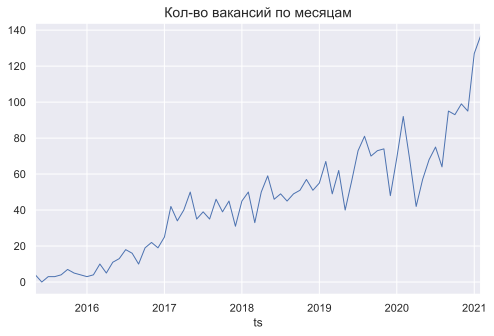

In [131]:
# –í—ã–±–∏—Ä–∞–µ–º —Ç–æ–ª—å–∫–æ —Å–æ–æ–±—â–µ–Ω–∏—è —Å –≤–∞–∫–∞–Ω—Å–∏—è–º–∏
df = messages[messages.is_job == 1].reset_index(drop=True)

# –£–±–∏—Ä–∞–µ–º —Å–æ–æ–±—â–µ–Ω–∏—è –Ω–∞—á–∏–Ω–∞—é—â–∏–µ—Å—è —Å —Ç–µ–≥–∞ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è
df = df[df['text'].str[0:2] != '<@']

plt.figure(figsize = (8, 5))
df[(df.ts < '2021-03-01')].resample('M', on = 'ts')['ts'].count().plot(linewidth=1)
plt.title('–ö–æ–ª-–≤–æ –≤–∞–∫–∞–Ω—Å–∏–π –ø–æ –º–µ—Å—è—Ü–∞–º', size=14)
plt.show()

### –ü–∞—Ä—Å–∏–Ω–≥ –∑–∞—Ä–ø–ª–∞—Ç 

–ü–æ –ø—Ä–∞–≤–∏–ª–∞–º —Å–æ–æ–±—â–µ—Å—Ç–≤–∞ –≤ –∫–∞–∂–¥–æ–π –≤–∞–∫–∞–Ω—Å–∏–∏ –¥–æ–ª–∂–Ω–∞ –±—ã—Ç—å —É–∫–∞–∑–∞–Ω–∞ –∑–∞—Ä–ø–ª–∞—Ç–Ω–∞—è –≤–∏–ª–∫–∞.<br>
–ù–æ –Ω–∞ –ø—Ä–∞–∫—Ç–∏–∫–µ —Å–ø–∞—Ä—Å–∏—Ç—å –∏—Ö –æ–∫–∞–∑–∞–ª–æ—Å—å –Ω–µ —Ç–∞–∫ –ø—Ä–æ—Å—Ç–æ.<p>
    
#### –û—á–∏—Å—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞

–í –≤–∞–∫–∞–Ω—Å–∏—è—Ö –µ—Å—Ç—å –º–Ω–æ–≥–æ –¥—Ä—É–≥–∏—Ö —Ü–∏—Ñ—Ä –ø–æ–º–∏–º–æ –∑–∞—Ä–ø–ª–∞—Ç–Ω—ã—Ö –≤–∏–ª–æ–∫, –∫–æ—Ç–æ—Ä—ã–µ –º–∞—à–∞—é—Ç –∞–Ω–∞–ª–∏–∑—É.
–î–ª—è –Ω–∞—á–∞–ª–∞ –æ—á–∏—Å—Ç–∏–º —Ç–µ–∫—Å—Ç –æ—Ç –Ω–∏—Ö:
<li>–°—Å—ã–ª–∫–∏
<li>–ù–æ–º–µ—Ä–∞ —Ç–µ–ª–µ—Ñ–æ–Ω–æ–≤
<li>–ì–æ–¥–∞
<li>–ò–Ω—Ç–µ—Ä–≤–∞–ª—ã –≤—Ä–µ–º–µ–Ω–∏
<li>–ü—Ä–µ–º–∏–∏

In [132]:
# –°—Å—ã–ª–∫–∞
link = r'<.*?>'

# –ù–æ–º–µ—Ä —Ç–µ–ª–µ—Ñ–æ–Ω–∞
tel = r'([78][-\( ]*\d{3}[-\) ]*\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3}|' + \
      r'\(\d{3}\)\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3})'

# –£–¥–∞–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è –ø—Ä–µ–º–∏–π
bonus = r'(\+.{0,5}?\d{2,3}.{0,25}?–ø—Ä–µ–º–∏|\+ \d{2-3}-\d{2,3}|\+ \d{2,3})'

# –û—á–∏—â–∞–µ–º —Ç–µ–∫—Å—Ç
df['clean_text'] = df.text
# –£–¥–∞–ª—è–µ–º –≤—Å–µ —Å—Å—ã–ª–∫–∏ –∏–∑ —Ç–µ–∫—Å—Ç–∞
df['clean_text'] = df.clean_text.str.replace(link, ' ')
# –£–¥–∞–ª—è–µ–º —Ç–µ–ª–µ—Ñ–æ–Ω—ã –∏–∑ —Ç–µ–∫—Å—Ç–∞
df['clean_text'] = df.clean_text.str.replace(tel, ' ')
# –£–¥–∞–ª—è–µ–º –ø—Ä–µ–º–∏–∏ –∏–∑ —Ç–µ–∫—Å—Ç–∞
df['clean_text'] = df.clean_text.str.replace(bonus, ' ')
# –£–¥–∞–ª—è–µ–º –≥–æ–¥–∞ –∏–∑ —Ç–µ–∫—Å—Ç–∞
df['clean_text'] = df.clean_text.replace(YEAR_RANGES_DICT, regex=True)
# –£–¥–∞–ª—è–µ–º –≤—Ä–µ–º—è –∏–∑ —Ç–µ–∫—Å—Ç–∞
df['clean_text'] = df.clean_text.replace(TIME_RANGES_DICT, regex=True)

#### –ë–∞–∑–æ–≤—ã–µ —Ä–µ–≥—É–ª—è—Ä–∫–∏ –¥–ª—è –∑–∞—Ä–ø–ª–∞—Ç–Ω—ã—Ö –≤–∏–ª–æ–∫

–î–ª—è –Ω–∞—á–∞–ª–∞ —Å–¥–µ–ª–∞–µ–º –Ω–µ—Å–∫–æ–ª—å–∫–æ —Ä–µ–≥—É–ª—è—Ä–æ–∫:
<li> –†–µ–≥–ª—è—Ä–∫–∞ –¥–ª—è –∏–∑–≤–µ–ª–µ–Ω–∏—è —Ü–∏—Ñ—Ä–≤ –≤ 4 —Ñ–æ—Ä–º–∞—Ç–∞—Ö
<li> –†–µ–≥—É–ª—è—Ä–∫–∞ –¥–ª—è –≤—ã—Ä–∞–∂–µ–Ω–∏—è –º–µ–∂–¥—É —Ü–∏—Ñ—Ä–∞–º–∏ –µ—Å–ª–∏ –æ–Ω–∏ –æ—Ç–Ω–æ—Å—Ç—è—Ç—Å—è –∫ –æ–¥–Ω–æ–π –≤–∏–ª–∫–µ
<li> –†–µ–≥—É–ª—è—Ä–∫–∞ –¥–ª—è –≤—ã—Ä–∞–∂–µ–Ω–∏–π –∫–æ—Ç–æ—Ä—ã–µ —á–∞—Å—Ç–æ –∏–¥—É—Ç –¥–æ —É–∫–∞–∑–∞–Ω–∏—è –∑–∞—Ä–ø–ª–∞–Ω–æ–π –≤–∏–ª–∫–∏
<li> –†–µ–≥—É–ª—è—Ä–∫–∞ –¥–ª—è –≤—ã—Ä–∞–∂–µ–Ω–∏–π –∫–æ—Ç–æ—Ä—ã–µ –∏–¥—É—Ç –ø–æ—Å–ª–µ –∑–∞—Ä–ø–ª–∞—Ç–Ω–æ–π –≤–∏–ª–∫–∏

In [133]:
number = r'([123456789]\d{0,2}[,\'\. ]?\d0{2}|[123456789]\d{2}0{1,2}|[123456789]\d{1,2}|[123456789]\d{0,1}[\.,\']\d{1,3})'

middle = r'[ \t]*[^0123456789\.,\'%]{0,9}?(?:-|–¥–æ|‚Äì|‚Äî|to|-)[ \t]*[^0123456789\.,\'%]{0,1}?'

start = r'(?:net|gross|–≥—Ä–æ—Å—Å|–Ω–µ—Ç|rub|$|‚Ç¨|¬£|eur|dol|mid|sen|jun|–º–∏–¥–ª|—Å–∏–Ω—å|–¥–∂—É–Ω|–∑–ø|–∑\\–ø|–ø–ª–∞—Ç|–∫–æ–º–ø–µ–Ω—Å–∞—Ü|' + \
        r'–≤–∏–ª–∫|–∑/–ø|–¥–æ—Ö–æ–¥|fork|moneys|salary|moneyparrot|–¥–µ–Ω—å–≥|–æ–∫–ª–∞–¥|—É—Å–ª–æ–≤–∏—è|—Å—Ç–∞–≤–∫–∞|_plug).{0,100}?\s*?'

end = r'[ \t]*?[^0123456789]{0,3}?(?:k |–∫ |—Ç—ã—Å\.|—Ç\.—Ä|net|gross|–≥—Ä–æ—Å—Å|–Ω–µ—Ç|rub|$|‚Ç¨|¬£|eur|dol|mid|' + \
      r'sen|jun|–º–∏–¥–ª|—Å–∏–Ω—å|jun|—Ä |–¥–∂—É–Ω)'

#### –§–∏–Ω–∞–ª—å–Ω—ã–µ —Ä–µ–≥—É–ª—è—Ä–∫–∏ –¥–ª—è –∏–∑–≤–ª–µ—á–µ–Ω–∏—è –≤–∏–ª–æ–∫

–¢–µ–ø–µ—Ä—å –∏–∑ –±–∞–∑–æ–≤—ã—Ö —Ä–µ–≥—É–ª—è—Ä–æ–∫ –º–æ–∂–Ω–æ —Å–æ–±—Ä–∞—Ç—å —Ñ–∏–Ω–∞–ª—å–Ω—ã–µ. –í –ø–æ—Ä—è–¥–∫–µ –ø—Ä–∏–æ—Ä–∏—Ç–µ—Ç–∞:
<ol>
    <li>–ü–æ–ª–Ω—ã–µ –≤–∏–ª–∫–∏ –æ—Ç –∏ –¥–æ –∏ —Å —Å–æ–≤–ø–∞–¥–µ–Ω–∏–µ–º –ø–æ —Ä–µ–≥—É–ª—Ä—è–∫–∞–º –¥–æ –∏ –ø–æ—Å–ª–µ
    <li>–ü–æ–ª–Ω—ã–µ –≤–∏–ª–∫–∏ –æ—Ç –∏ –¥–æ –∏ —Å —Å–æ–≤–ø–∞–¥–µ–Ω–∏–µ–º –ø–æ —Ä–µ–≥—É–ª—Ä—è–∫–∞–º –ø–æ—Å–ª–µ
    <li>–ü–æ–ª–Ω—ã–µ –≤–∏–ª–∫–∏ –æ—Ç –∏ –¥–æ –∏ —Å —Å–æ–≤–ø–∞–¥–µ–Ω–∏–µ–º –ø–æ —Ä–µ–≥—É–ª—Ä—è–∫–∞–º –¥–æ
    <li>–ü–æ–ª–Ω—ã–µ –≤–∏–ª–∫–∏ –æ—Ç –∏ –¥–æ
    <li>–í–∏–ª–∫–∏ –∏–∑ –æ–¥–Ω–æ–π —Ü–∏—Ñ—Ä—ã —Å —Å–æ–≤–ø–∞–¥–µ–Ω–∏–µ–º –ø–æ —Ä–µ–≥—É–ª—Ä—è–∫–∞–º –¥–æ –∏ –ø–æ—Å–ª–µ
    <li>–í–∏–ª–∫–∏ –∏–∑ –æ–¥–Ω–æ–π —Ü–∏—Ñ—Ä—ã —Å —Å–æ–≤–ø–∞–¥–µ–Ω–∏–µ–º –ø–æ —Ä–µ–≥—É–ª—Ä—è–∫–∞–º –ø–æ—Å–ª–µ
    <li>–í–∏–ª–∫–∏ –∏–∑ –æ–¥–Ω–æ–π —Ü–∏—Ñ—Ä—ã —Å —Å–æ–≤–ø–∞–¥–µ–Ω–∏–µ–º –ø–æ —Ä–µ–≥—É–ª—Ä—è–∫–∞–º –¥–æ

In [134]:
fork_1 = start + number + middle + number + end
fork_2 = number + middle + number + end
fork_3 = start + number + middle + number
fork_4 = number + middle + number
fork_5 = start + number + end

In [135]:
# –ü–∞—Ä—Å–∏–º –≤–∏–ª–∫–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –ø–æ–ª—É—á–µ–Ω–Ω—ã—Ö —Ä–µ–≥—É–ª—è—Ä–æ–∫
forks_1 = df.clean_text.str.findall(fork_1)
forks_2 = df.clean_text.str.findall(fork_2)
forks_3 = df.clean_text.str.findall(fork_3)
forks_4 = df.clean_text.str.findall(fork_4)
clean_text = df.clean_text.str.replace(fork_4, ' ')
forks_5 = clean_text.str.findall(fork_5)

forks_list = []
for i, row in df.iterrows():
    forks = forks_1[i] + forks_2[i] + forks_3[i] + forks_4[i] + forks_5[i]
    forks_list.append(forks)
    
df['forks'] = forks_list

print(f'–í—Å–µ–≥–æ –Ω–∞–π–¥–µ–Ω–æ –≤–∏–ª–æ–∫ {np.sum(df.forks.str.len() > 0)} –∏–∑ {len(df)}')

–í—Å–µ–≥–æ –Ω–∞–π–¥–µ–Ω–æ –≤–∏–ª–æ–∫ 3212 –∏–∑ 3872


#### –ü–∏–≤–µ–¥–µ–º –≤—Å–µ –≤–∏–ª–∫–∏ –∫ –æ–¥–Ω–æ–º—É —Ñ–æ—Ä–º–∞—Ç—É

–ü—Ä–∏–≤–µ–¥–µ–º –≤–∏–ª–∫–∏ —Å–æ—Å—Ç–æ—è—â–∏–µ –∏–∑ –æ–¥–Ω–æ–≥–æ —á–∏—Å–ª–∞ –∫ –≤–∏–¥—É –Ω–∏–∂–Ω—è—è –≥—Ä–∞–Ω–∏—Ü–∞ - –≤–µ—Ä—Ö–Ω—è—è –≥—Ä–∞–Ω–∏—Ü–∞<br>
–†–∞—Å–ø–∞—Ä—Å–∏–º —á–∏—Å–ª–∞ –∏–∑ —Å—Ç—Ä–æ–∫–æ–≤–æ–≥–æ —Ñ–æ—Ä–º–∞—Ç–∞ –∏ –ø—Ä–∏–≤–µ–¥–µ–º –∫ —Ç—ã—Å—è—á–∞–º<br>
–£–¥–∞–ª–∏–º –¥—É–±–ª–∏ –ø–æ –≤–∏–ª–∫–∞–º –∏ –≤–∏–ª–∫–∏ —Å –Ω–µ—Å–æ–≤–ø–∞–¥–µ–Ω–∏—è–º–∏ –ø–æ –≥—Ä–∞–Ω–∏—Ü–∞–º

In [136]:
df['forks'] = format_forks(df)
print(f'–ö–æ–ª-–≤–æ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ —Ñ–æ—Ä–º–∞—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –≤–∏–ª–æ–∫ {np.sum(df.forks.str.len()>0)}')   

–ö–æ–ª-–≤–æ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ —Ñ–æ—Ä–º–∞—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –≤–∏–ª–æ–∫ 3190


#### –î–æ–±–∞–≤–∏–º –≤–∞–ª—é—Ç—É –∏ –ø—Ä–∏–∑–Ω–∞–∫ net –∏–ª–∏ –≥—Ä–æ—Å—Å
–ü–µ—Ä–µ—Å—á–∏—Ç–∞–µ–º –∑–∞—Ä–ø–ª–∞—Ç—ã –≤ —Ä—É–±–ª—è—Ö –≤ net

In [137]:
df['cur'] = get_currency(df)
print(f'–í–∞–ª—é—Ç—ã –≤–∞–∫–∞–Ω—Å–∏–π: {df.cur.value_counts().to_dict()}')

df['tax'] = get_tax(df)
print(f'–î–æ/–ø–æ—Å–ª–µ –Ω–∞–ª–æ–≥–æ–≤: {df.tax.value_counts().to_dict()}')

df['forks'] = df.apply(apply_tax, axis=1)

–í–∞–ª—é—Ç—ã –≤–∞–∫–∞–Ω—Å–∏–π: {'rub': 2271, 'usd': 540, 'eur': 364, 'gbp': 15}
–î–æ/–ø–æ—Å–ª–µ –Ω–∞–ª–æ–≥–æ–≤: {'net': 2134, 'gross': 1056}


#### –î–æ–±–∞–≤–∏–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –ø–æ —É—Ä–æ–≤–Ω—è–º
–ß–∞—Å—Ç–æ –≤ –æ–¥–Ω–æ–π –≤–∞–∫–∞–Ω—Å–∏–∏ –∏—â—É—Ç —Å—Ä–∞–∑—É –Ω–µ—Å–∫–æ–ª—å–∫–æ —Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç–æ–≤, –∏–¥–µ—Ç –ø–µ—Ä–µ—á–∏—Å–ª–µ–Ω–∏–µ —É—Ä–æ–≤–Ω–µ–π –∏ –≤–∏–ª–æ–∫.

In [138]:
print(f'–í–∞–∫–∞–Ω—Å–∏–π —Å –¥–≤—É–º—è –∏ –±–æ–ª–µ–µ –≤–∏–ª–∫–∞–º–∏: {np.sum(df.forks.str.len() > 1)}')

–í–∞–∫–∞–Ω—Å–∏–π —Å –¥–≤—É–º—è –∏ –±–æ–ª–µ–µ –≤–∏–ª–∫–∞–º–∏: 634


–î–æ–±–∞–≤–∏–º –≥—Ä–µ–π–¥ –≤–∞–∫–∞–Ω—Å–∏–∏ –∫–∞–∫ –Ω–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫. –ò –µ—Å–ª–∏ —É –≤–∞–∫–∞–Ω—Å–∏–∏ –Ω–µ—Å–∫–æ–ª—å–∫–æ –≤–∏–ª–æ–∫ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–∏–º –∏—Ö –ø–æ —É—Ä–æ–≤–Ω—è–º.

In [139]:
df = add_levels_cols(df)
df = add_levels_forks(df)
print('–ö–æ–ª-–≤–æ –≤–∞–∫–∞–Ω—Å–∏–π –ø–æ –ø–æ–∑–∏—Ü–∏—è–º:')
print(f'\tjunior: {np.sum(df.junior)}')
print(f'\tmiddle {np.sum(df.middle)}')
print(f'\tsenior: {np.sum(df.senior)}')
print(f'\tlead: {np.sum(df.lead)}')

–ö–æ–ª-–≤–æ –≤–∞–∫–∞–Ω—Å–∏–π –ø–æ –ø–æ–∑–∏—Ü–∏—è–º:
	junior: 666
	middle 1206
	senior: 1253
	lead: 1012


### –ê–Ω–∞–ª–∏–∑ –∑–∞—Ä–ø–ª–∞—Ç

#### –ó–∞—Ä–ø–ª–∞—Ç–Ω—ã–µ –≤–∏–ª–∫–∏ –ø–æ –≥—Ä–µ–π–¥–∞–º

–í–æ–∑—å–º–µ–º —Ç–æ–ª—å–∫–æ –≤–∞–∫–∞–Ω—Å–∏–∏ —É–∫–∞–∑–∞–Ω–Ω—ã–µ –≤ —Ä—É–±–ª—è—Ö, –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –≥—Ä–µ–π–¥–∞ —É–±–µ—Ä–µ–º –≤—ã–±—Ä–æ—Å—ã –ø–æ –∑–∞—Ä–ø–ª–∞—Ç–Ω–æ–π –≤–∏–ª–∫–∏<br>

In [140]:
rub = df[df.cur == 'rub']
level_bounds = get_quantiles(rub)
rub['junior_fork'], rub['middle_fork'], rub['senior_fork'], rub['lead_fork'] = "[]", "[]", "[]", "[]"
rub = estimate_level_forks(rub, level_bounds)

for level in LEVELS_DICT.keys():
    rub[level+'_fork'] = rub[level+'_fork'].apply(json.loads)

–ì—Ä–∞–Ω–∏—Ü—ã –≤–∏–ª–æ–∫ –¥–ª—è junior: {'bottom': [30.0, 100.0], 'upper': [40.0, 150.0]}
–ì—Ä–∞–Ω–∏—Ü—ã –≤–∏–ª–æ–∫ –¥–ª—è middle: {'bottom': [87.0, 174.0], 'upper': [139.0, 250.0]}
–ì—Ä–∞–Ω–∏—Ü—ã –≤–∏–ª–æ–∫ –¥–ª—è senior: {'bottom': [100.0, 250.0], 'upper': [167.0, 400.0]}
–ì—Ä–∞–Ω–∏—Ü—ã –≤–∏–ª–æ–∫ –¥–ª—è lead: {'bottom': [100.0, 350.0], 'upper': [150.0, 500.0]}


In [141]:
box_plot_by_level(rub)

–ù–∞ —ç—Ç–æ–º –≥—Ä–∞—Ñ–∏–∫–µ –º—ã —Å–º–æ—Ç—Ä–∏–º –Ω–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å—Ä–µ–¥–Ω–µ–≥–æ –º–µ–∂–¥—É –≤–µ—Ä—Ö–Ω–µ–π –∏ –Ω–∏–∂–Ω–µ–π –≥—Ä–∞–Ω–∏—Ü–µ–π –≤–∏–ª–∫–∏.<br>
–ù–∞—Å—Ç–æ—è—â–∏–µ —Ü–∏—Ñ—Ä—ã –º–æ–≥—É—Ç –±—É—Ç—å –Ω–µ–º–Ω–æ–≥–æ —Å–º–µ—â–µ–Ω—ã –≤–≤–µ—Ä—Ö –∏–ª–∏ –≤–Ω–∏–∑ –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç —Ç–æ–≥–æ,<br> 
–∫—É–¥–∞ –≤ —Å—Ä–µ–¥–Ω–µ–º —Ç—è–≥–æ—Ç–µ–µ—Ç —Ñ–∏–Ω–∞–ª—å–Ω—ã–π –æ—Ñ—Ñ–µ—Ä.<p>

#### –ó–∞—Ä–ø–ª–∞—Ç–Ω—ã–µ –≤–∏–ª–∫–∏ –ø–æ —É—Ä–æ–≤–Ω—è–º

# –ê–Ω–∞–ª–∏–∑ —Ç–∏–ø–∞ –≤–∞–∫–∞–Ω—Å–∏–π

In [173]:
df['de'] = df['clean_text'].str.contains('data engineer|–¥–∞—Ç–∞ –∏–Ω–∂–µ–Ω–µ—Ä|–¥–∞—Ç–∞-–∏–Ω–∂–µ–Ω–µ—Ä|data-–∏–Ω–∂–µ–Ω–µ—Ä|data –∏–Ω–∂–µ–Ω–µ—Ä', regex=True)
df.de.value_counts()

False    3376
True      496
Name: de, dtype: int64

In [178]:
de_list = list(df[df.de].index)

In [189]:
for de_index in de_list[200:]:
    print(df.loc[de_index, 'text'])
    print('\n***********************************************************************')
    print('***********************************************************************\n')

–≤—Å–µ–º –ø—Ä–∏–≤–µ—Ç! –º—ã –≤—Å–µ –µ—â–µ –∞–∫—Ç–∏–≤–Ω–æ –ø—Ä–æ–¥–æ–ª–∂–∞–µ–º –Ω–∞–±–∏—Ä–∞—Ç—å –ª—é–¥–µ–π –≤ –Ω–∞—à—É r&amp;d –∫–æ–º–∞–Ω–¥—É. –∏—â–µ–º *mid/sr data scientist/ml engineer* –∏ *mid/sr data engineer*. —Å—Ñ–µ—Ä–∞ - natural language processing.
–∫–æ–º–ø–∞–Ω–∏—è *ihs markit*
–≥–æ—Ä–æ–¥  :flag-by: *–º–∏–Ω—Å–∫, —Ä–±* (—É–¥–∞–ª–µ–Ω–Ω–æ —Ç–æ–∂–µ —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞–µ–º)
:fork:  *$2500-4000 (—á–∏—Å—Ç—ã–º–∏)*
* *
*—Ç—Ä–µ–±–æ–≤–∞–Ω–∏—è –∫* *data scientist/ml engineer*:
‚Ä¢ python 
‚Ä¢ –≤—ã—Å—à–µ–µ –æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤ cs/ml/ds –∏–ª–∏ —Å–º–µ–∂–Ω–æ–π –æ–±–ª–∞—Å—Ç–∏
‚Ä¢ —É–≤–µ—Ä–µ–Ω–Ω–æ–µ –ø–æ–Ω–∏–º–∞–Ω–∏–µ ml/dl-–º–µ—Ç–æ–¥–æ–≤, –∑–Ω–∞–Ω–∏–µ —Ç–µ–æ—Ä–∏–∏ –∏ –ø—Ä–∞–∫—Ç–∏–∫–∏ –∏—Ö –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è
‚Ä¢ –±–æ–ª—å—à–æ–π –ø—Ä–∞–∫—Ç–∏—á–µ—Å–∫–∏–π –æ–ø—ã—Ç –≤ —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–µ ml/dl-—Ä–µ—à–µ–Ω–∏–π —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º tensorflow/keras (–∏–ª–∏ pytorch)
‚Ä¢ –∑–Ω–∞–Ω–∏–µ –ø—Ä–∏–Ω—Ü–∏–ø–æ–≤ –æ–æ–ø –∏ —Ñ–ø
‚Ä¢ english (b1+)
 
*—Ç—Ä–µ–±–æ–≤–∞–Ω–∏—è –∫ data engineer*:
‚Ä¢ pyt

–ù—É–∂–Ω–æ —É–±—Ä–∞—Ç—å –≤—Å–µ *
* –≤ –Ω–∞—à—É –∫–æ–º–∞–Ω–¥—É deloitte analytics institute –º—ã –∏—â–µ–º data engineer'a
* –ø—Ä–æ–¥—É–∫—Ç–æ–≤—ã—Ö –∞–Ω–∞–ª–∏—Ç–∏–∫–æ–≤
* –≤–∞–∫–∞–Ω—Å–∏—è - senior data scientist
* –ø—Ä–æ–¥–æ–ª–∂–∞–µ–º –ø–æ–∏—Å–∫ –≤ –Ω–∞—à—É –∫–æ–º–∞–Ω–¥—É –¥–∞—Ç–∞-–∏–Ω–∂–µ–Ω–µ—Ä–∞
* –∏—â–µ–º data scientist ... –¥–∞–Ω–Ω—É—é —Ä–∞–±–æ—Ç—É –∫–∞–∫ –ø—Ä–∞–≤–∏–ª–æ –¥–µ–ª–∞–µ—Ç data engineer, –Ω–æ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ —É–º–µ—Ç—å –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–æ–≤–∞—Ç—å —Å –Ω–∏–º
* –≤ –ø–æ–∏—Å–∫–∞—Ö big data engineer
* big data engineer
* –≤ onefactor –∏—â–µ–º ds/de middle/junior —É—Ä–æ–≤–Ω—è.
* *position*: senior data engineer
* –∏—â–µ–º –¥–∞—Ç–∞ –∏–Ω–∂–µ–Ω–µ—Ä–∞ –≤ –∫–æ–º–∞–Ω–¥—É
* –∏—â–µ–º –≤ *–±–∏–ª–∞–π–Ω* –∏–Ω–∏—Ü–∏–∞—Ç–∏–≤–Ω–æ–≥–æ data scientist'–∞
* middle data scientist –¥–ª—è –Ω–æ–≤—ã—Ö –∑–∞–¥–∞—á –≤ –∫–æ–º–ø–∞–Ω–∏–∏*
* *job title* : junior+/middle data scientist
* –æ–ø—ã—Ç —Ä–∞–±–æ—Ç—ã –¥–∞—Ç–∞ –∏–Ω–∂–µ–Ω–µ—Ä–æ–º –æ—Ç 2 –ª–µ—Ç
* –∏—â–µ–º middle+ data engineer
* –Ω—É–∂–Ω—ã –ø—Ä–æ—Ñ–∏ –ø–æ ml/cv –∏ data engineer/data science
* –∏—â–µ—Ç data engineer'–æ–≤ –∏ data scientist'–æ–≤
* –∏—â–µ–º *middle/senior data engineer*
* –∏—â–µ–º:* senior dataengineer
* –≤–∞–∫–∞–Ω—Å–∏—è: data engineer
* *–ø–æ–∑–∏—Ü–∏—è*:\n senior data scientist
* *—Ä–æ–ª—å: senior data engineer*
* –≤–∞–∫–∞–Ω—Å–∏–∏: ml —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫/ data engineer(python)
* –∏—â—É ml —Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫–∞/ data engineer
* –¥–∞—Ç–∞ –∏–Ω–∂–µ–Ω–µ—Ä –≤ efx –∫–æ–º–∞–Ω–¥—É –≤—Ç–±
–ú–æ–∂–Ω–æ –Ω–∞—Ö–æ–¥–∏—Ç—å –≤ —Ç–µ–∫—Å—Ç–µ –≤—Å–µ —Å–æ–≤–ø–∞–¥–µ–Ω–∏—è –ø–æ Data Engineer –∏ —Ä—è–¥–æ–º —Å n —Å–ª–æ–≤–∞–º–∏ –ø—Ä–æ–≤–µ—Ä—è—Ç—å, —á—Ç–æ –≤—Å—Ç—Ä–µ—á–∞–µ—Ç—Å—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω–æ–µ —Å–ª–æ–≤–æ (–∫ –ø—Ä–∏–º–µ—Ä—É: –≤–∞–∫–∞–Ω—Å–∏ –∏–ª–∏ –ø–æ–∑–∏—Ü–∏

## –û–±—â–∏–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã –¥–ª—è –ø–∞—Ä—Å–∏–Ω–≥–∞ –≤–∞–∫–∞–Ω—Å–∏–π

In [669]:
grade_keywords = {
    'intern', 'junior', 'middle', 'senior', 'lead', '—Å—Ç–∞–∂[–µ—ë]—Ä', '–¥–∂—É–Ω', '–º–∏–¥–¥?–ª',
    '—Å[–µ–∏]–Ω[—å–µ–∏—ë][–æ–µ]—Ä', '–ª–∏–¥', '—Å—Ç–∞—Ä—à–∏–π', '–≥–ª–∞–≤–Ω—ã–π', '–≤–µ–¥—É—â', 'head'
}

main_keywords = {'–≤–∞–∫–∞–Ω—Å–∏', '–ø–æ–∑–∏—Ü–∏', '—Ä–æ–ª[—å–∏]', '–¥–æ–ª–∂–Ω–æ—Å—Ç', 'title', 'job', 'vacancy', 'role', 'position',
     '–∏—â–µ[–º—Ç]', '—Ç—Ä–µ–±—É–µ—Ç—Å—è', '–Ω–∞–±[–æ–∏]—Ä', '–∏—Å–∫–∞—Ç', '–ø—Ä–∏–≥–ª–∞—à', '–∏—â—É', '–∏—â–µ–º', '–∏—â–µ—Ç', '–Ω—É–∂–µ–Ω', '–Ω—É–∂–Ω',
     '—Ç—Ä–µ–±—É–µ—Ç—Å—è', '—Ä[–æ–∞]–∑—ã—Å–∫', '–∫–æ–≥–æ', '–∫—Ç–æ', '—É—Ä–æ–≤–Ω—è', '—É—Ä–æ–≤–µ–Ω—å'
}.union(grade_keywords)

keywords = {
     '–º–æ–ø–µ–¥', '–≤ –∫–æ–º–∞–Ω–¥—É', '–ø–æ–∏—Å–∫', '–Ω–∞ —Ä–∞–±–æ—Ç—É', '–≤ –∫–æ–º–ø–∞–Ω–∏—é', 'company', '–∑–ø', '–∑–∞—Ä–∞–±–æ—Ç–Ω', '–∑–∞—Ä–ø–ª–∞—Ç',
     '–≤–∏–ª–∫', '–Ω–∞ —Ä–∞–±–æ—Ç—É', '–æ–∫–ª–∞–¥', 'salary', '—Ñ–æ—Ä–º–∞—Ç', '—Ä–∞—Å–ø–∏—Å–∞–Ω–∏', '—Å—Ç–∞–≤–∫–∞', '–ø—Ä–æ–¥–æ–ª–∂–∞–µ–º', '–æ–ø—ã—Ç',
     'experience', 'requirement', '–æ–∂–∏–¥–∞', '–∑–∞–¥–∞—á', '—Ä—É–∫–æ–≤–æ–¥–∏—Ç–µ–ª', '—Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç', '–∫–∞–Ω–¥–∏–¥–∞—Ç', '—Å–æ—Ç—Ä—É–¥–Ω',
     '–∫—Ç–æ', '–∫–æ—Ç–æ—Ä—ã–π', '—Å—Ç–∞—Ä—Ç-?–∞–ø', '–µ–¥–∏–Ω–æ–º—ã—à–ª–µ–Ω–Ω–∏', '—É–¥–∞–ª[–µ—ë]–Ω–∫', '—É–¥–∞–ª[–µ—ë]–Ω–Ω?–æ', '–æ—Ñ–∏—Å', 'remote', 'office',
     'format', 'schedule', 'prerequisites', 'fork', 'expect', 'candidate', 'specialist', 'location', '–ª–æ–∫–∞—Ü–∏—è',
     'start-?up', '—Ä–∞—Å—Å–º–æ—Ç—Ä[–µ–∏]', '–æ—Ç–¥–µ–ª', 'department'
}.union(main_keywords)


def get_pattern(main_keywords, keywords, task_keywords, title_keywords, k=60, n=30):
    main_keywords = '|'.join(main_keywords)
    keywords = '|'.join(keywords.union(task_keywords))
    title_keywords = '|'.join(title_keywords)
    
    pattern = (f'^' + '.{,' + str(k) + '}' + f'({title_keywords})|'
         + f'(({main_keywords})' + '.{,' + str(n) + '}' + f'({title_keywords}))|'
         + f'(({title_keywords})' + '.{,' + str(n) + '}' + f'({main_keywords}))|'
         + f'(({keywords})' + '.{,' + str(n) + '}' + f'({title_keywords})' + '.{,' + str(n) + '}' + f'({keywords}))')
    return pattern

## Data Engineer

In [697]:
task_keywords = {'etl', 'dwh', 'olap', '–≤–∏—Ç—Ä–∏–Ω—ã', 'data mart', '–∏–Ω—Ñ—Ä–∞—Å—Ç—Ä—É–∫—Ç—É—Ä', 'infrastructure'}

n = 10
title_keywords = {
    '(data|–¥–∞—Ç–∞).{,' + str(n) + '}(engineer|–∏–Ω–∂–µ–Ω–µ—Ä)',
    '(engineer|–∏–Ω–∂–µ–Ω–µ—Ä)–∞?\W(of|–ø–æ)?\W(–¥–∞–Ω–Ω—ã|data|big)',
    '(de?)\W(engineer|–∏–Ω–∂–µ–Ω–µ—Ä)',
    '\Wde\W',
}

pattern = get_pattern(main_keywords, keywords, task_keywords, title_keywords)

df['de'] = df['clean_text'].str.contains(pattern)
print('–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π Data Engineer: {}'.format(len(df[df.de])))

–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π Data Engineer: 439


## Data Analyst

In [694]:
task_keywords = {}

title_keywords = {
    '(data|–¥–∞—Ç–∞).{,' + str(n) + '}(analyst|–∞–Ω–∞–ª–∏—Ç–∏–∫|–∞–Ω–∞–ª–∏—Å—Ç)',
    '(analyst|–∞–Ω–∞–ª–∏—Ç–∏–∫|–∞–Ω–∞–ª–∏—Å—Ç)–∞?\W(of|–ø–æ)?\W?(–¥–∞–Ω–Ω—ã|data|big|ds)',
    '(da|ds).?(analyst|–∞–Ω–∞–ª–∏—Ç–∏–∫|–∞–Ω–∞–ª–∏—Å—Ç)',
    'da.?engineer',
    'da.?–∞–Ω–∞–ª–∏—Å—Ç',
    'da.?–∞–Ω–∞–ª–∏—Ç–∏–∫',
    'da.?–∏–Ω–∂–µ–Ω–µ—Ä',

    'ds.?analyst',
    'ds.?–∞–Ω–∞–ª–∏—Ç–∏–∫',
    'ds.?–∞–Ω–∞–ª–∏—Å—Ç',
    
    '\Wda\W'
}

pattern = get_pattern(main_keywords, keywords, task_keywords, title_keywords)

df['da'] = df['clean_text'].str.contains(pattern)
print('–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π Data Analyst: {}'.format(len(df[df.da])))

–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π Data Analyst: 304


## Data Scientist

In [699]:
task_keywords = {}
remove_keywords = {}
title_keywords = {
    '(data|–¥–∞—Ç–∞).{,' + str(n) + '}(scientist|—Å–∞–π?–µ?–Ω—Ç–∏—Å—Ç|—Å–∞—Ç–∞–Ω–∏—Å—Ç)',
    '(ds|data\Wscience)\W(researcher|engineer|–∏—Å—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å|–∏–Ω–∂–µ–Ω–µ—Ä)',
#     '\Wds\W',
}

pattern = get_pattern(main_keywords, keywords, task_keywords, title_keywords)

df['ds'] = df['clean_text'].str.contains(pattern)
print('–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π Data Scientist: {}'.format(len(df[df.ds])))

–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π Data Scientist: 1103


In [653]:
remove_keywords = {}
title_keywords = {
    '\Wds\W'
}

pattern2 = get_pattern(main_keywords, keywords, task_keywords, title_keywords)

df['ds2'] = df['clean_text'].str.contains(pattern2)
print('–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π Data Scientist: {}'.format(len(df[df.ds2])))

–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π Data Scientist: 419


## ML Engineer

In [626]:
task_keywords = {}
title_keywords = {'ml[ -]engineer', 'ml[ -]–∏–Ω–∂–µ–Ω–µ—Ä', 'ml[ -]developer', 'ml[ -]—Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫',
                  '–º–ª[ -]engineer', '–º–ª[ -]–∏–Ω–∂–µ–Ω–µ—Ä', '–º–ª[ -]developer', '–º–ª[ -]—Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫',
                  'machine[ -]learning[ -]engineer', '—Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫ –º–∞—à–∏–Ω–Ω–æ–≥–æ –æ–±—É—á–µ–Ω–∏—è',
                  '—Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫ –º–ª', '—Ä–∞–∑—Ä–∞–±–æ—Ç—á–∏–∫ ml', 'mle'}

pattern = get_pattern(main_keywords, keywords, task_keywords, title_keywords)

df['ml'] = df['clean_text'].str.contains(pattern)
print('–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π ML Engineer: {}'.format(len(df[df.ml])))

–ù–∞—à–ª–æ—Å—å –≤–∞–∫–∞–Ω—Å–∏–π ML Engineer: 327


In [295]:
string = '*–∫–æ–º–ø–∞–Ω–∏—è:* —Å–ø–æ—Ä—Ç–º–∞—Å—Ç–µ—Ä \n*–ø–æ–∑–∏—Ü–∏—è*: data engineer \n*—É—Ä–æ–≤–µ–Ω—å:* middle \n*–≤–∏–ª–∫–∞*'
re.search(pattern, string)

<re.Match object; span=(26, 49), match='–ø–æ–∑–∏—Ü–∏—è*: data engineer'>

# –ê–Ω–∞–ª–∏–∑ —Å—Ç–µ–∫–∞ —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏–π

In [146]:
df['year'] = df['ts'].dt.year

In [156]:
technologies = {
    'tensorflow': ['tensorflow', 'tf'],
    'pytorch': ['pytorch'],
    'keras': ['keras'],
}

for technology, keywords in technologies.items():
    keywords_regex = '|'.join(keywords)
    df[technology] = df['clean_text'].str.contains(keywords_regex, regex=True)

In [157]:
data = df[df.is_job == 1].groupby('year').sum()[['tensorflow', 'pytorch', 'keras']].reset_index()
data = data.melt(
    id_vars="year",
    var_name="category", 
    value_name="quantity",
)

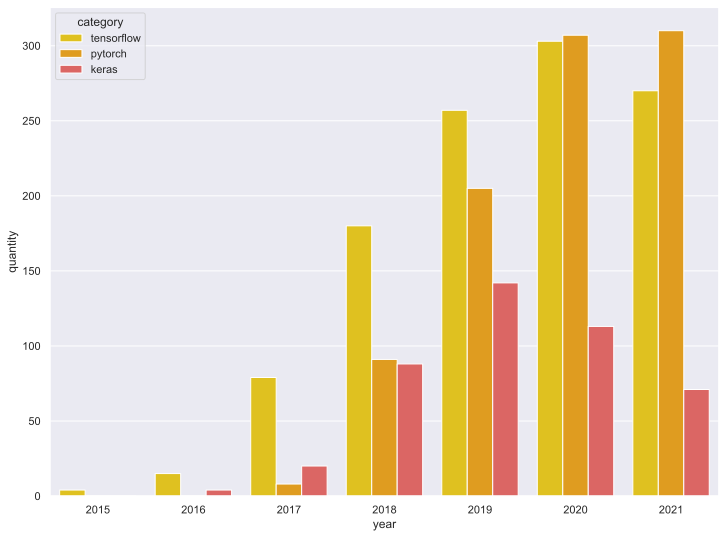

In [163]:
colors = ['gold', 'orange', '#EF5350', '#9839DA', '#0EC7F5']
sns.barplot(data=data_, x='year', y='quantity', hue='category', palette=sns.color_palette(colors))